In [1]:
# Preface
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)
import numpy as np
from os.path import isdir
from os import makedirs
from collections import OrderedDict

%matplotlib inline
import matplotlib.pyplot as plt

from sys import path as syspath
syspath.append("./functions/")
from os.path import isfile
from physio_def_1 import *

In [2]:
from plotFirst_1 import plotImage

In [3]:
# if autocompletion does not work:
%config Completer.use_jedi = False

In [4]:
# if you have retina display:
%config InlineBackend.figure_format = 'retina'

In [85]:
# pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Sandra/20190812/Experiment28.lif'
# pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Ya-Chi/Oct 4 2019_cleaned.lif'
pathToFile = '//s2/physio/team/slakrupnik/project/experiments/Old/2013_03_19/Pancreas islet OGB 56.lif'
assert isfile(pathToFile)

In [86]:
md = bf.get_omexml_metadata(pathToFile)
xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
rdr = bf.ImageReader(pathToFile, perform_init=True)
extension = "."+pathToFile.split(".")[-1]

OrderedDict([(i,xml.image(i).Name) for i in range(Nimages)])

OrderedDict([(0, 'Image002'),
             (1, 'Series003'),
             (2, 'Image004'),
             (3, 'Image006'),
             (4, 'Series007'),
             (5, 'Image008'),
             (6, 'Image010'),
             (7, 'Series011'),
             (8, 'Image012'),
             (9, 'Image015'),
             (10, 'Series016'),
             (11, 'Image017'),
             (12, 'Image019'),
             (13, 'Series020'),
             (14, 'Image021'),
             (15, 'Image024'),
             (16, 'Series025'),
             (17, 'Image026'),
             (18, 'Image028'),
             (19, 'Series029'),
             (20, 'Image030'),
             (21, 'Image032'),
             (22, 'Series033'),
             (23, 'Image034'),
             (24, 'Series007Snapshot1'),
             (25, 'Series007Snapshot2'),
             (26, 'Series016Snapshot1'),
             (27, 'Series016Snapshot2'),
             (28, 'Series016Snapshot3'),
             (29, 'Series025Snapshot1'),
            

# Which Series?

In [87]:
iSeries = 16

im = xml.image(iSeries)
Name = im.Name
dimensions = dict(zip("TXY",(getattr(im.Pixels, "Size"+dim) for dim in "TXY")))

if dimensions["T"]>1:
    dimensions['freq'] = getApparentFreq(iSeries,xml)

In [88]:
dimensions

{'T': 3658, 'X': 512, 'Y': 512, 'freq': 1.000272976081231}

## Import First Few Frames just to get an idea

In [34]:
howManyFirstFrames = 1000
firstFrames = importFrames(rdr,idx=iSeries, which=(howManyFirstFrames,))

if len(firstFrames.shape)>3:
    print("There are more dimensions here than expected.\nI'll remedy this for now, but be shure to keep this in mind.")
    extraDims = True
    retainDims = np.where(firstFrames.std(axis=tuple(range(len(firstFrames.shape)-1)))>0)[0]
    assert len(retainDims)==1
    retainDims = retainDims[0]
    firstFrames = firstFrames.T[retainDims].T

meanFirstFrames = firstFrames.mean(axis=0)
stdFirstFrames = firstFrames.std(axis=0)

There are more dimensions here than expected.
I'll remedy this for now, but be shure to keep this in mind.


In [35]:
firstFrames.shape

(1000, 100, 512)

In [36]:
pxSize = im.Pixels.get_PhysicalSizeX()
pxUnit = im.Pixels.get_PhysicalSizeXUnit()
text = "\n".join([" %s:%i"%(c,dimensions[c])  for c in "XYT"])
if dimensions["T"]>1:
    text += "\n f:%.1f Hz"%dimensions['freq']

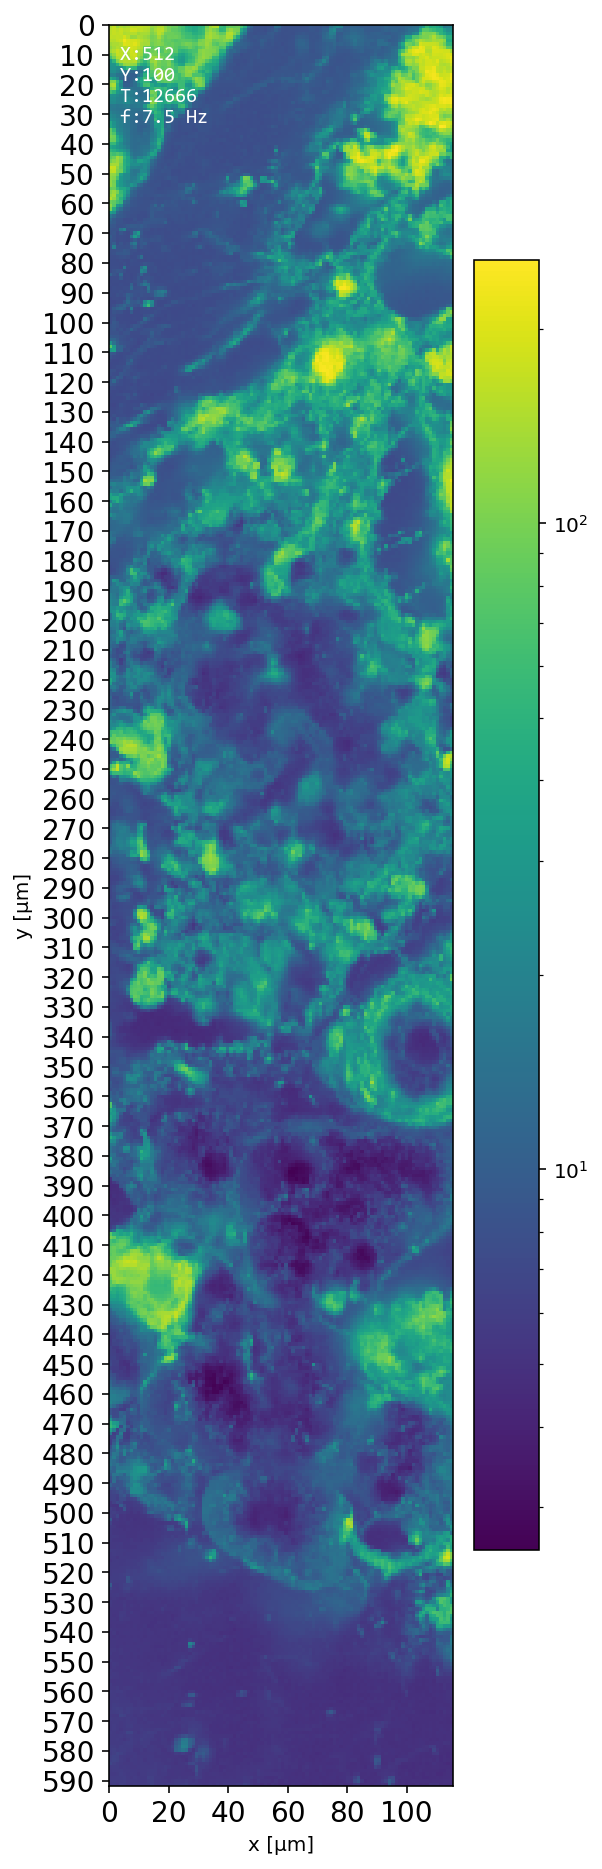

In [37]:
plotImage(meanFirstFrames.T,pxSize=pxSize,pxUnit=pxUnit,
          rescale=1./30,
          #savePath=pathToFile[:-4]+"_%s_first_mean.png"%(Name),
          addInfo=text)

In [38]:
# plotImage(stdFirstFrames.T,pxSize=pxSize,pxUnit=pxUnit,
#           rescale=1./30,
#           #savePath=pathToFile[:-4]+"_%s_first_std.png"%(Name),
#           # addInfo=text
#          )

# Be more precise what to import

In [65]:
# which time frames to import?
importT = np.arange(0,1000) # first 1000
# # other options:
# importT = np.arange(0,dimensions["T"])     # all
# importT = np.arange(0,dimensions["T"],100) # every 100th frame
# this choice here will affect time it takes to import

In [66]:
# here you choose which pixels to import
# they need to be in the format (from,to)
importX = ( 10,100) # from  10th (incl) until 100th (excl)
importY = (100,150) # from 100th (incl) until 150th (excl)
# # If you want all pixels, you can put 
# importX = None
# importY = None
# This choice does not affect the time, but only memory footprint

In [67]:
%%time
image = importFrames(
    rdr,
    idx=iSeries,
    which=(importT,importX,importY)
)
if extraDims:
    image = image.T[retainDims].T

Wall time: 5.1 s


In [68]:
image.shape

(1000, 90, 50)

In [69]:
# importing times
time = getTimes(xml_=xml,idx_=iSeries)[importT]

## plot all image

In [72]:
slowTimescale = 20 # in seconds
tWin=int(slowTimescale*dimensions["freq"])

Text(0.5, 0, 'time [s]')

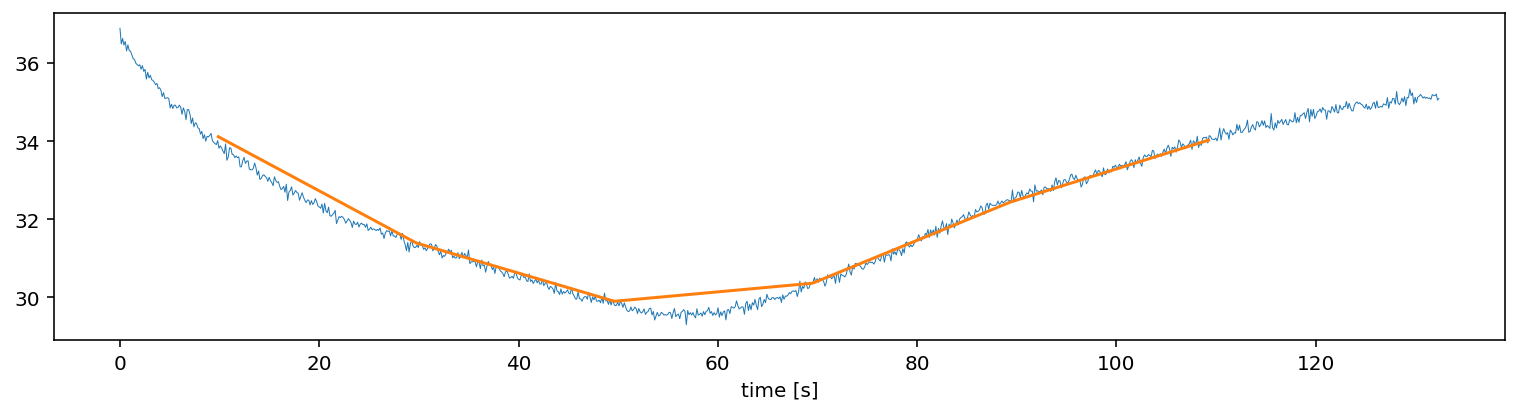

In [73]:
plt.figure(figsize=(13,3))

plt.plot(time,image.mean(axis=(1,2)), lw=.5)

plt.plot(rebin(time,tWin),
         rebin(image.mean(axis=(1,2)),tWin))
plt.xlabel("time [s]")

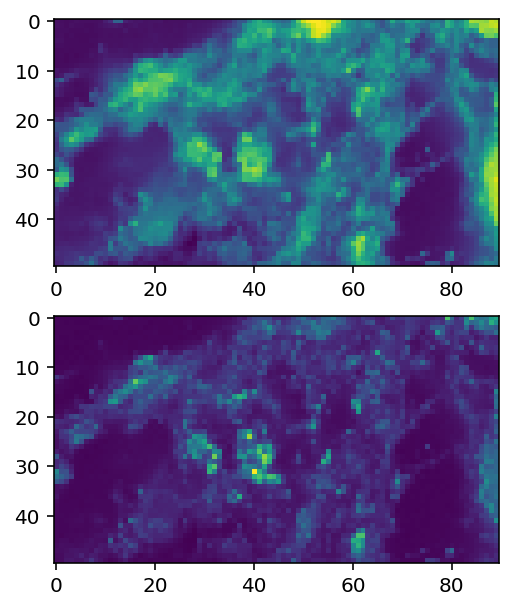

In [75]:
# the simplest plot of the mean and std:
plotImageWithRois(
            image_=image,
            stdDev=True,
        );

# Define Rois

In [76]:
# For now, only square rois can be added.
# Rois are a represnted as a dictionary of square *origins* (not centers as in previous versions)
# This way Rois have unique names
# For example:
RoiOrigins = OrderedDict([
    ("left" , (10,30)),
    ("right", (60, 0))
])

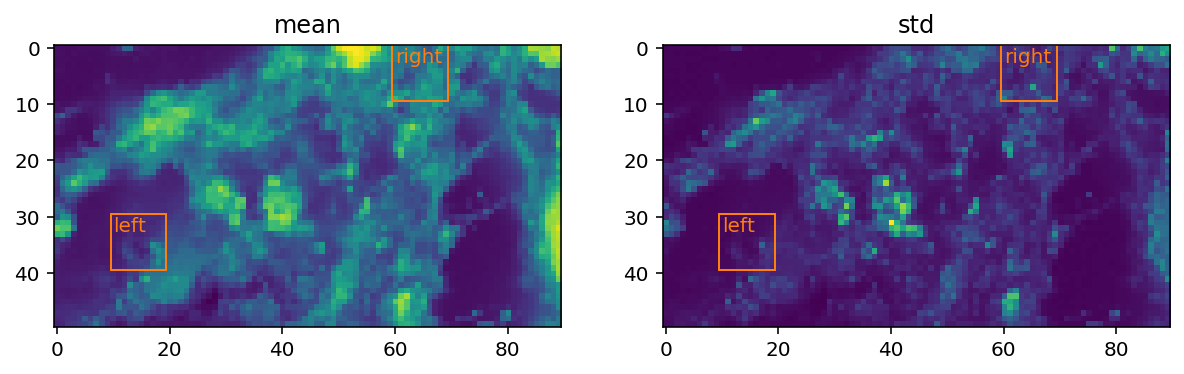

In [77]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
plotImageWithRois(RoiOrigins,
            pxWin = 10, # this sets the size of the square rois (exaclty, unlike previously)
            image_=image,
            stdDev=True,
            axs =axs,
            label=True
        );
for ax,name in zip(axs,["mean","std"]):
    ax.set_title(name)

In [78]:
# we can obtain the time profile of the rois (already time averaged)
roiProfiles = getRoiProfiles(image_=image,pxShows=RoiOrigins,pxWin=10,tWin_=tWin)
# the result is also dictionary
roiProfiles.keys()

odict_keys(['left', 'right'])

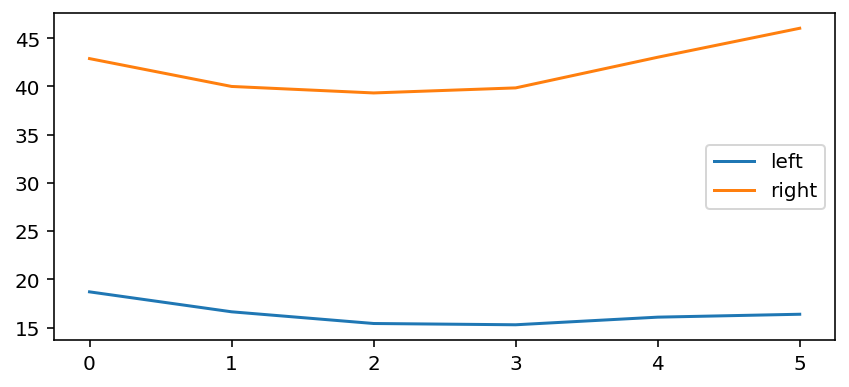

In [79]:
# we can plot the time profiles
plt.figure(figsize=(7,3))
for k in roiProfiles:
    plt.plot(roiProfiles[k],label=k)
plt.legend()

## We can combine the whole thing into a single figure

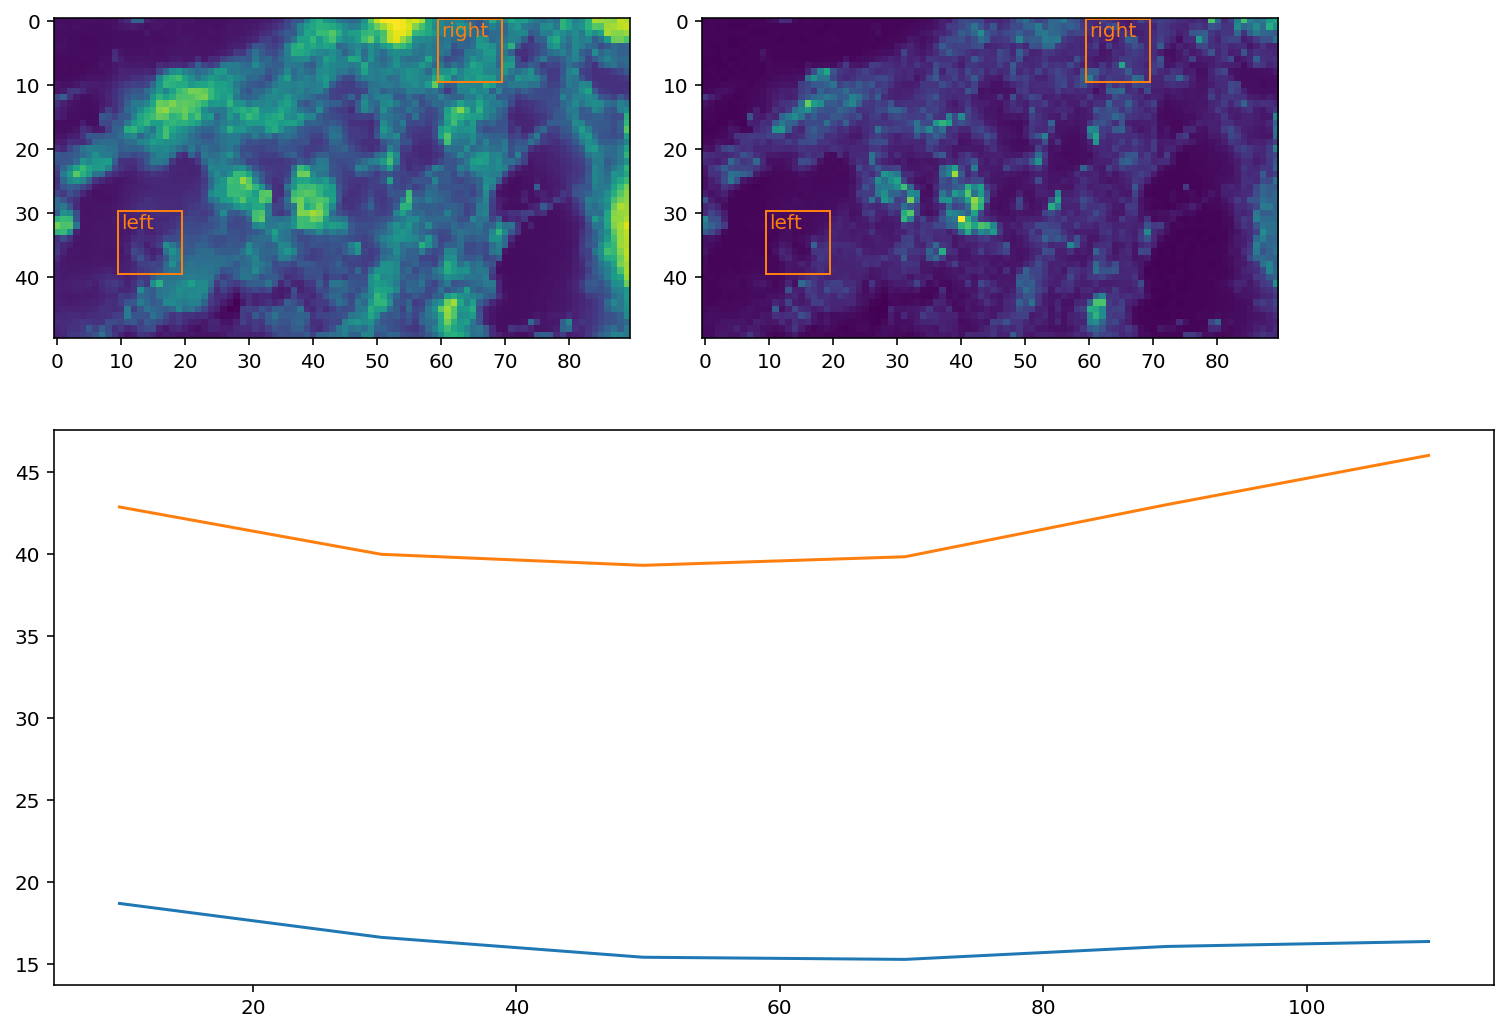

In [81]:
pxWin = 10
RoiOrigins = OrderedDict([
    ("left" , (10,30)),
    ("right", (60, 0))
])

fig = plt.figure(figsize=(10,7))

axsUp = [
    fig.add_axes([0,.6,.4,.4]),
    fig.add_axes([.45,.6,.4,.4])
]
plotImageWithRois(RoiOrigins,
            pxWin   = pxWin,
            image_=image,
            stdDev=True,
            axs =axsUp,
            label=True
        );

roiProfiles = getRoiProfiles(image_=image,pxShows=RoiOrigins,pxWin=pxWin,tWin_=tWin)

ax = fig.add_axes([0,0,1,.55])
for roiLabel in roiProfiles:
    ax.plot(rebin(time,tWin),roiProfiles[roiLabel], label=roiLabel)

# ax.legend(ncol=len(roiProfiles)//20+1)

## Or have an automatic labels of the rois

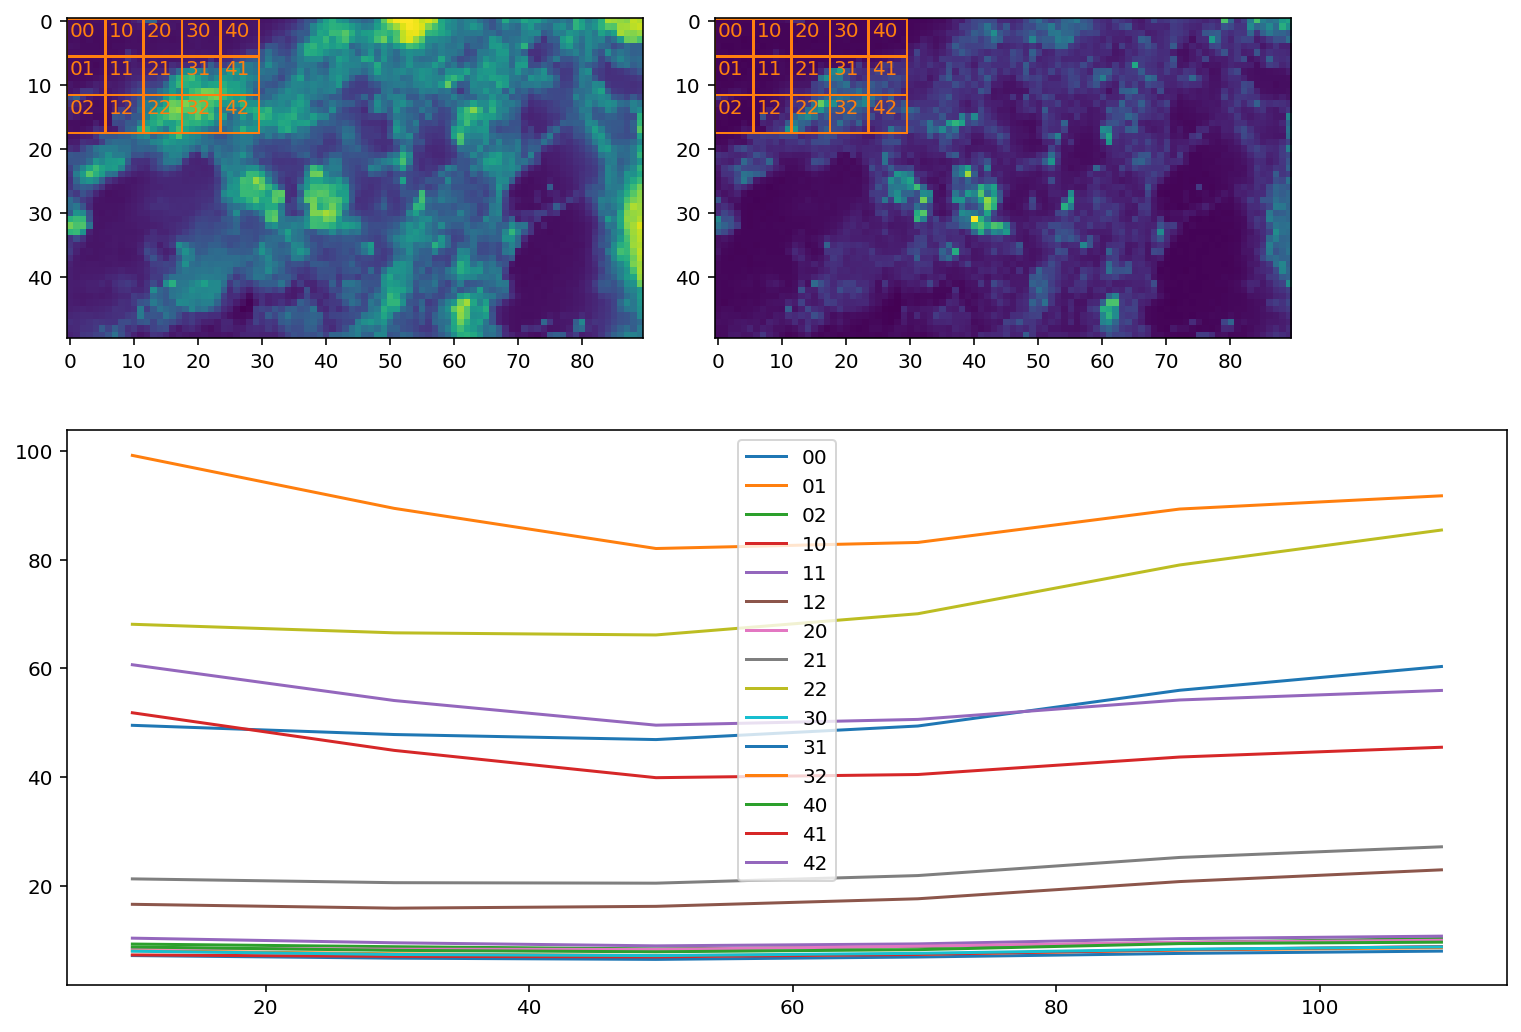

In [82]:
pxWin = 6
RoiOrigins = OrderedDict([("%i%i"%(i,j),(i*pxWin,j*pxWin)) for i in range(5)
                          for j in range(3)])

fig = plt.figure(figsize=(10,7))

axsUp = [
    fig.add_axes([0,.6,.4,.4]),
    fig.add_axes([.45,.6,.4,.4])
]
plotImageWithRois(RoiOrigins,
            pxWin   = pxWin,
            image_=image,
            stdDev=True,
            axs =axsUp,
            label=True
        );

roiProfiles = getRoiProfiles(image_=image,pxShows=RoiOrigins,pxWin=pxWin,tWin_=tWin)

ax = fig.add_axes([0,0,1,.55])
for roiLabel in roiProfiles:
    ax.plot(rebin(time,tWin),roiProfiles[roiLabel], label=roiLabel)

ax.legend(ncol=len(roiProfiles)//20+1)

## Or even...

__FYI:__ RoiOrigins can also be a list. In this case, it is treated as a dictionary, 
where the key is the element index. Let me illustrate on a subset of the image:

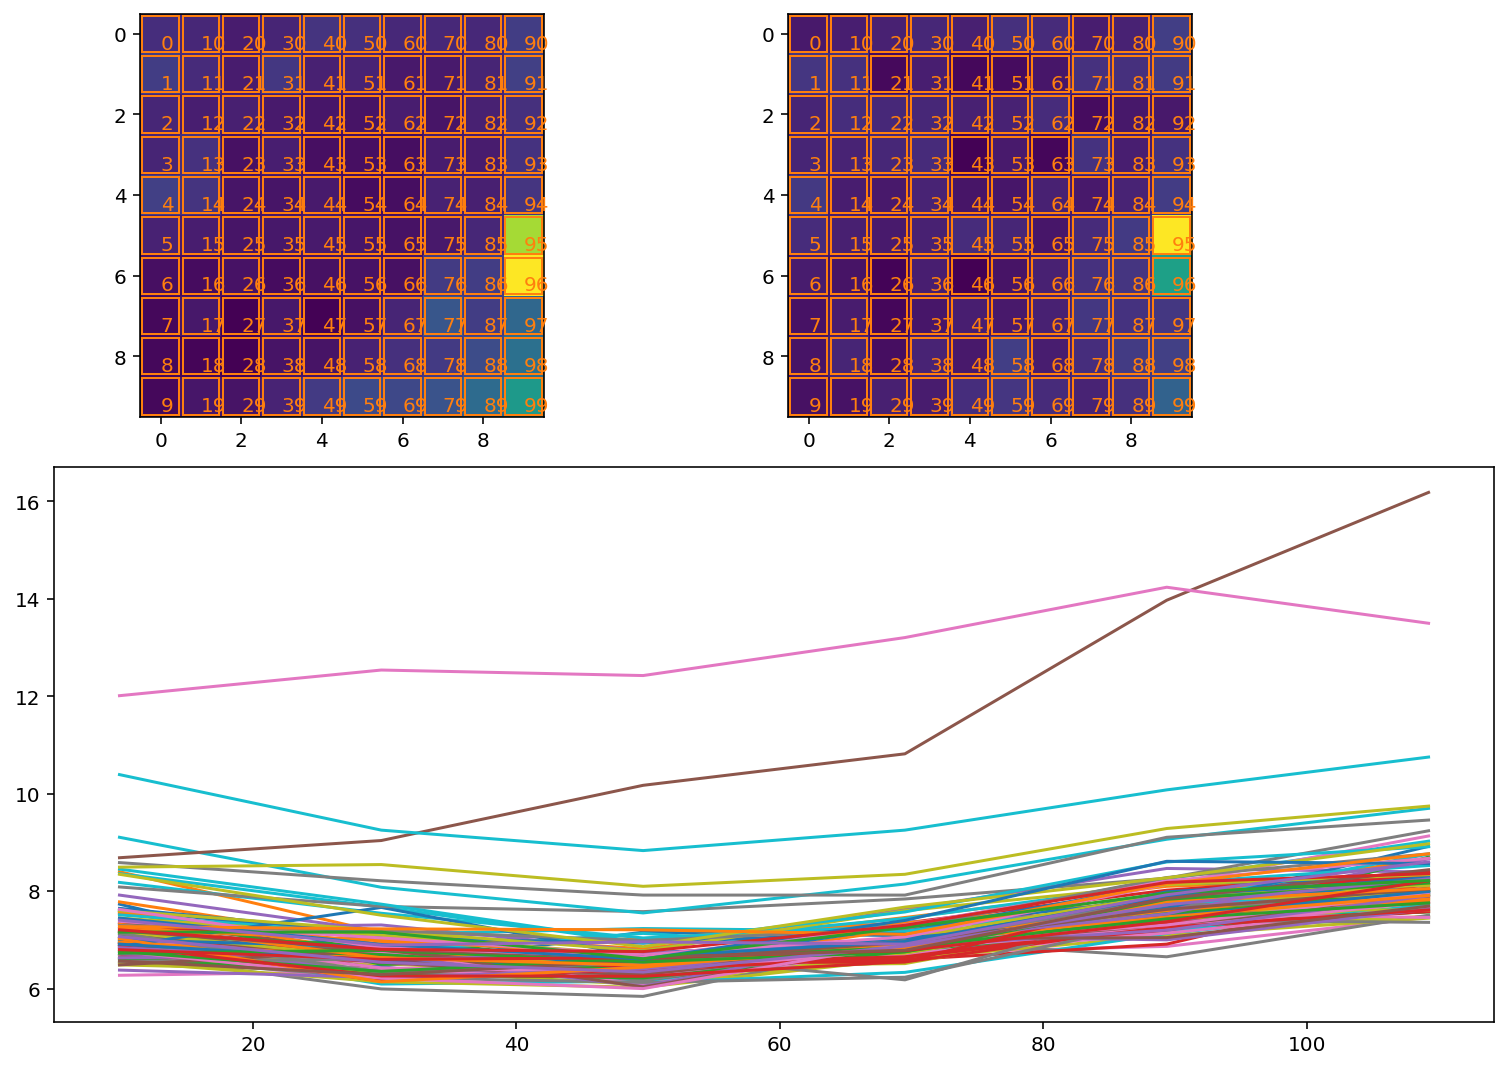

In [84]:
subimage = image[:,:10,:10]
pxWin = 1
RoiOrigins = [(i*pxWin,j*pxWin) for i in range(subimage.shape[1]) for j in range(subimage.shape[2])]

fig = plt.figure(figsize=(10,7))

axsUp = [
    fig.add_axes([0,.6,.4,.4]),
    fig.add_axes([.45,.6,.4,.4])
]
plotImageWithRois(RoiOrigins,
            pxWin   = pxWin,
            image_=subimage,
            stdDev=True,
            axs =axsUp,
            label=True
        );

roiProfiles = getRoiProfiles(image_=subimage,pxShows=RoiOrigins,pxWin=pxWin,tWin_=tWin)

ax = fig.add_axes([0,0,1,.55])
for roiLabel in roiProfiles:
    ax.plot(rebin(time,tWin),roiProfiles[roiLabel], label=roiLabel)

# ax.legend(ncol=len(roiProfiles)//20+1)